In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import chisquare

from tqdm.auto import tqdm
from scipy.stats import iqr
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(
    font_scale =1,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [3]:
# зададим параметры отображения
pd.set_option('display.max_colwidth', 0)
pd.options.display.max_columns = None

## Задание 1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания проанализирую итоги эксперимента и сделаю вывод, стоит ли запускать новую механику оплаты на всех пользователей.

###  Замечания

В связи с тем, что таблица groups_add.csv была передана спустя два дня после получения основных данных, а о происхождении добавленных пользователей мы ничего не знаем, и о периоде проведения эксперимента тоже ничего не знаем, то будем считать, что эти данные собирались из разных источников, но в рамках проведения эксперимента. Поэтому включаем пользователей из таблицы groups_add.csv в АБ-тест.

## Недостающая информация
- В задании упоминается "в ходе тестирования одной гипотезы...", но о самой гипотезе ничего не сказано.    Ничего неизвестно о периоде проведения эксперимента. Неизвестно в разрезе какого временного показателя (месяц, неделя, день) на наших руках данные.
- Неизвестно на что опираются новая/старая механики оплаты услуг на сайте и какие целевые действия производит пользователь перед тем как перейти к оплате.
- Неизвестно откуда появились пользователи из таблицы groups_add.csv. Участвовали ли они с самого запуска эксперимента или же были довалены откуда-то отдельно.
- Неизвестно каким образом формировалась колонка rev в таблице checks.csv. Это суммы всех оплат каждого пользователя за n-ый период времени или это одна единственная оплата.

**Входные данные**

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.

- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [4]:
groups,group_add,active_studs,checks = (
                                       pd.read_csv("Проект_2_groups.csv",sep= ";"),
                                       pd.read_csv("Проект_2_group_add.csv",sep= ","),
                                       pd.read_csv("Проект_2_active_studs.csv",sep= ";"),
                                       pd.read_csv("Проект_2_checks.csv",sep= ";")
                                       )

In [5]:
def info(df):
    print("*" * 10)
    print("head:")
    print(df.head())
    print("*" * 10)
    print("shape:")
    print(df.shape)
    print("*" * 10)
    print("dtpyes:")
    print(df.dtypes)
    print("*" * 10)
    print("count_null:")
    print(df.isna().sum())
    print("*" * 10)
    print("count_duplicates:")
    print(df.duplicated().sum())
    print("*" * 10)

In [6]:
info(groups)

**********
head:
     id grp
0  1489  B 
1  1627  A 
2  1768  B 
3  1783  B 
4  1794  A 
**********
shape:
(74484, 2)
**********
dtpyes:
id     int64 
grp    object
dtype: object
**********
count_null:
id     0
grp    0
dtype: int64
**********
count_duplicates:
0
**********


In [7]:
info(group_add)

**********
head:
        id grp
0  5694584  B 
1  5694830  B 
2  5695057  B 
3  5698872  B 
4  5699067  B 
**********
shape:
(92, 2)
**********
dtpyes:
id     int64 
grp    object
dtype: object
**********
count_null:
id     0
grp    0
dtype: int64
**********
count_duplicates:
0
**********


In [8]:
info(active_studs)

**********
head:
   student_id
0  581585    
1  5723133   
2  3276743   
3  4238589   
4  4475369   
**********
shape:
(8341, 1)
**********
dtpyes:
student_id    int64
dtype: object
**********
count_null:
student_id    0
dtype: int64
**********
count_duplicates:
0
**********


In [9]:
info(checks)

**********
head:
   student_id    rev
0  1627        990.0
1  3185        690.0
2  25973       690.0
3  26280       690.0
4  100300      990.0
**********
shape:
(541, 2)
**********
dtpyes:
student_id    int64  
rev           float64
dtype: object
**********
count_null:
student_id    0
rev           0
dtype: int64
**********
count_duplicates:
0
**********


**Разведочный анализ данных (exploratory data analysis, EDA)**

In [10]:
groups.rename(columns={ groups.columns[0]: "student_id"}, inplace = True) 
group_add.rename(columns={ group_add.columns[0]: "student_id"}, inplace = True)
full_groups = groups.append(group_add) # сформируем общий df для дальнейшего анализа

In [11]:
full_groups.loc[full_groups.duplicated()] # Проверяем на дубликаты

,student_id,grp


In [12]:
full_groups.value_counts("grp")

grp
B    59883
A    14693
dtype: int64

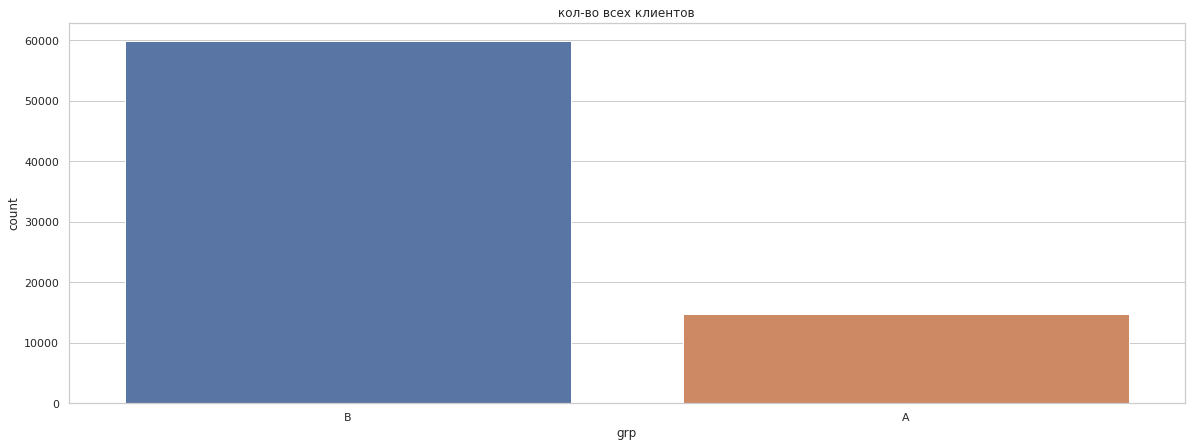

In [13]:
# Визуализируем распределения пользователей в двух группах
sns.countplot(data=full_groups,x="grp").set(title=' кол-во всех клиентов ');

In [14]:
round(active_studs.shape[0] / full_groups.shape[0] * 100,2) #  % пользователей, посетивших сайт во время эксперемента.

11.18

In [15]:
checks.shape[0] - checks.merge(active_studs, on = "student_id").shape[0] 

149

149 пользователей, оплатившие услугу, отсутсвуют в таблице **active_studs**. Вероятно всего у сервиса есть некая система автоплатежа либо это и есть новая механика оплаты которую мы проверяем (а может быть еще что у пользователей вообще есть другая возможность пользоваться сервисом).В дальнейшем будем всех оплативших пользователей учитывать в эксперименте.

Посмотрим на распределение чеков между всеми платящами пользователями в дни эксперемента

In [16]:
checks.rename(columns={ checks.columns[1]: "revenue"}, inplace = True) 
checks.revenue.value_counts().reset_index().rename(columns={ "index": "revenue",checks.columns[1]: "count"}) 

,revenue,count
0,1900.0000,97
1,290.0000,94
2,690.0000,78
3,199.0000,46
4,990.0000,41
5,1900.0001,36
6,840.0000,27
7,1140.0000,25
8,580.0000,15
9,590.0000,11


In [17]:
checks

,student_id,revenue
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [18]:
checks['revenue'].describe()

count    541.000000 
mean     1059.752317
std      762.712359 
min      199.000000 
25%      290.000000 
50%      840.000000 
75%      1900.000000
max      4650.000000
Name: revenue, dtype: float64

In [19]:
checks["payed"] = 1 # Создаем столбец -payed, который принимает значение 1 , если пользователь совершил покупку, чтобы в дальнейшем было проще обращаться к этой группе покупателей.

In [20]:
active_studs2 = checks.merge(active_studs, on = "student_id",how = "outer") # К таблице с чеками добавляем юзеров, которые были на платформе в день эксперимента.

In [21]:
active_studs2.duplicated().sum()

0

In [22]:
full_groups = active_studs2.merge(full_groups, on = "student_id",how = "left") 
full_groups # получаем сформированный df для анализа

,student_id,revenue,payed,grp
0,1627,990.0,1.0,A
1,3185,690.0,1.0,B
2,25973,690.0,1.0,B
3,26280,690.0,1.0,B
4,100300,990.0,1.0,B
...,...,...,...,...
8485,264371,NaN,NaN,B
8486,1794344,NaN,NaN,B
8487,296883,NaN,NaN,B
8488,3598448,NaN,NaN,B


In [23]:
full_groups.query("grp == 'A'").revenue.sum()

92096.0

In [24]:
full_groups.query("grp == 'A' & payed > 0").revenue.quantile(q=[0.25,0.5,0.75])

0.25    290.0
0.50    690.0
0.75    990.0
Name: revenue, dtype: float64

In [25]:
full_groups.query("grp == 'B'").revenue.sum()

481230.0036

In [26]:
full_groups.query("grp == 'B' & payed > 0").revenue.quantile(q=[0.25,0.5,0.75])

0.25    420.75 
0.50    935.00 
0.75    1900.00
Name: revenue, dtype: float64

In [27]:
full_groups.query("grp == 'A' & payed > 0").revenue.nunique()

23

In [28]:
full_groups.query("grp == 'B' & payed > 0").revenue.nunique()

35

In [29]:
full_groups.query("grp == 'A' & payed > 0").revenue.value_counts()

290.0     31
690.0     19
199.0     7 
990.0     6 
580.0     6 
1140.0    5 
590.0     5 
3660.0    3 
1530.0    3 
840.0     3 
398.0     2 
1160.0    2 
489.0     2 
1980.0    2 
2820.0    2 
2910.0    2 
2890.0    1 
2900.0    1 
2220.0    1 
1180.0    1 
870.0     1 
1830.0    1 
1039.0    1 
Name: revenue, dtype: int64

In [30]:
full_groups.query("grp == 'B' & payed > 0").revenue.value_counts()

1900.0000    97
290.0000     63
690.0000     59
199.0000     39
1900.0001    36
990.0000     35
840.0000     24
1140.0000    20
580.0000     9 
398.0000     7 
590.0000     6 
870.0000     5 
1530.0000    5 
2890.0000    3 
2099.0000    3 
1980.0000    2 
3660.0000    2 
2910.0000    2 
796.0000     1 
630.0000     1 
1180.0000    1 
880.0000     1 
3040.0000    1 
2190.0000    1 
1968.0000    1 
1160.0000    1 
1729.0000    1 
2220.0000    1 
4650.0000    1 
1339.0000    1 
1388.0000    1 
489.0000     1 
3260.0000    1 
1050.0000    1 
597.0000     1 
Name: revenue, dtype: int64

В двух группах замечено большое количество одинаковых оплат, но при этом в эксперементальной группе у пользователей         отмечено гораздо большая вариативность размера оплат. Возможно связано это с новой механикой оплаты где у пользователей мог появиться некий нижний порог оплаты услуги и/или более оптимальные(гибкие) варианты покупки, при которых можно было бы приобрести только часть услуги. Также непонятно, откуда такой дисболанс группы чеков в эксперементальной группе. Тут мы тоже остаемся без ответа, хорошо бы переговорить с нашим продуктовым менеджером и командой маркетинга о происхождении таких оплат. Также хорошо бы заодно спросить, почему у нас в выборке есть практически два одинаковых счета (**'1900.0000'** & **'1900.0001'**) с высокой частотой. Мог быть это как раз тот нижний порог для покупку конретной услуги или получение скидки?       

Не понятно...

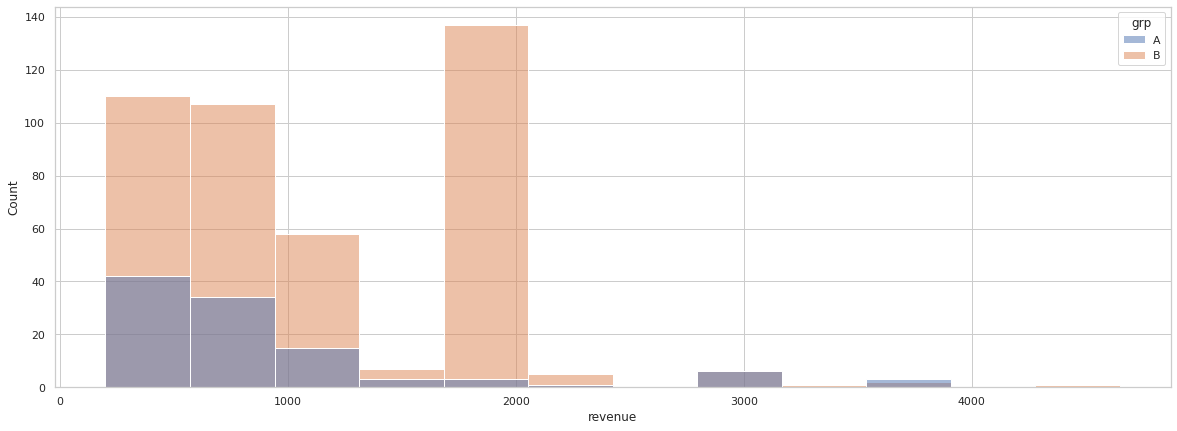

In [31]:
sns.histplot(data=full_groups.query("payed == 1")[['revenue', 'grp']], x ='revenue', hue ='grp');

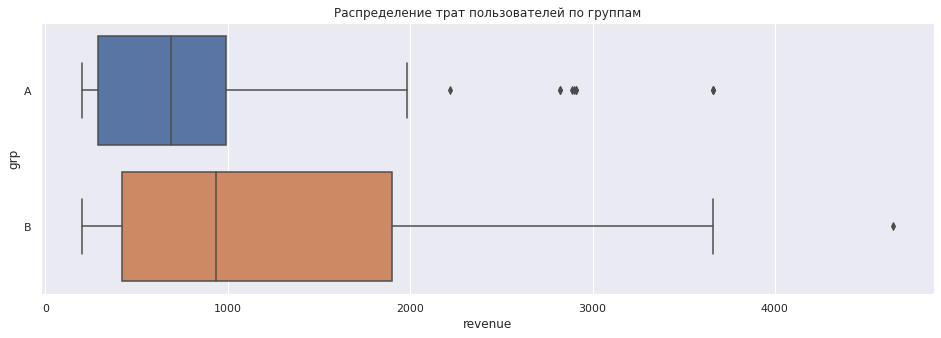

In [32]:
sns.set(rc={'figure.figsize':(16,5)})
sns.boxplot(data=full_groups, x=full_groups.query("payed == 1").revenue, y=full_groups.grp)\
            .set(title='Распределение трат пользователей по группам');

In [33]:
# можно применить тест Шапиро-Уилка, но он покажет тот же результат
stats.normaltest(full_groups.query("grp == 'B' & payed == 1")["revenue"])  

NormaltestResult(statistic=33.19587456725772, pvalue=6.18881394639434e-08)

In [34]:
stats.normaltest(full_groups.query("grp == 'A' & payed == 1")["revenue"])

NormaltestResult(statistic=52.21845240353401, pvalue=4.580439316510776e-12)

Распределение каждой из групп являетеся ненормальным,  также оба имеют большие выбросы, что в дальнейшем может повлиять на точность теста

По имеющимся данным просчитаем следующие метрики:

- **CR** Конверсия пользователя в покупку % 

- **ARPU** Средний платеж на одного пользователя

- **ARPPU** Средний платеж от одного платящего пользователя 

- **Mean_revenue** Средний доход от платящих пользователей 

In [35]:
Metrics = pd.DataFrame()
Metrics["payed_users"] = full_groups.query("payed == 1").groupby("grp")\
                    .student_id.count()
Metrics["active_users"] = full_groups.groupby("grp")\
                    .student_id.count()
Metrics["CR"] = round(Metrics["payed_users"] / Metrics["active_users"] * 100,2)
Metrics["ARPPU"] = round(full_groups.query("payed == 1").groupby("grp")\
                    .revenue.mean(),2)
Metrics["ARPU"] = round(full_groups.groupby("grp")\
                    .revenue.sum() / Metrics["active_users"],2)
Metrics["Mean_revenue"] = round(full_groups.query("payed == 1").groupby("grp").revenue.mean(),2)
Metrics

,payed_users,active_users,CR,ARPPU,ARPU,Mean_revenue
A,107,1567,6.83,860.71,58.77,860.71
B,434,6923,6.27,1108.82,69.51,1108.82


In [36]:
full_groups

,student_id,revenue,payed,grp
0,1627,990.0,1.0,A
1,3185,690.0,1.0,B
2,25973,690.0,1.0,B
3,26280,690.0,1.0,B
4,100300,990.0,1.0,B
...,...,...,...,...
8485,264371,NaN,NaN,B
8486,1794344,NaN,NaN,B
8487,296883,NaN,NaN,B
8488,3598448,NaN,NaN,B


Чтобы посчитать статистическую значимость между двумя группами можно было воспользоваться непараметрическим критерием независимых выборок U - test, но поскольку у нас очень много одинаковых оплат в двух группах,то при ранжировании и  при парном сравнение сумм индификаторов двух групп получим некорректный результат. Поэтому для корретного проведения эксперемента  воспользуюсь бутсрапом,и проверим все основные метрики(CR,ARPPU,ARPU), но чтобы не увеличить шанс допустить ошибку второго рода, опираться будем на результаты целевой метрики - конверсии в покупку (**CR**), т.к она лучше покажет изминение в целевое действие пользователя( если оно есть). 

Хотя требование к распределению не соблюдено, можно провести t test (ARPPU), но для этого важно проверить равенство дисперсий в двух выборках (гомогенность)

In [37]:
stats.levene(full_groups.query("grp == 'A' & payed == 1").revenue, full_groups.query("grp == 'B' & payed == 1").revenue)

LeveneResult(statistic=4.478900854248498, pvalue=0.03477352573759214)

p-value < 0.05. Дисперсии обоих групп не однородны. Хотя у нас выборки имеют не так много наблюдений и это могло сказаться  на тест, проверять гипотезу будем только бутсрапом.

**Проверка гипотезы**

**H0** - Конверсии в двух группах равны, CR_A==CR_B.    
**H1** - Конверсии в двух группах не равны, CR_A!=CR_B.

In [38]:
def get_bootstrap(
    data_column_1, #  1 группа
    data_column_2, # 2 группа
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика 
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    boot_len  = max([len(data_column_1), len(data_column_2)])
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [39]:
# Подкорректируем функции для бутстрапа
def cr(x):
    'расчет CR'
    return (len([i for i in x if i>0]) / len(x))

def arpu(x):
    'расчет ARPU'
    return np.sum(x) / len([i for i in x if i>0]) 

def arppu(x):
    'расчет ARPPU'
    return np.mean(x)

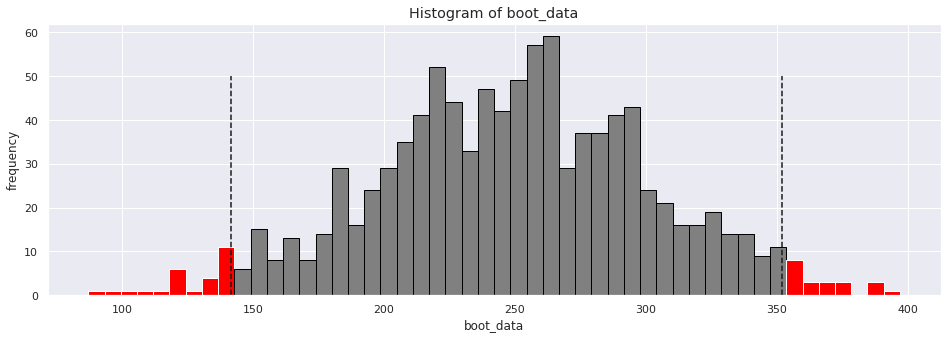

In [40]:
booted_data_ARPU = get_bootstrap(full_groups.query('grp =="B"').revenue.fillna(0), full_groups.query('grp =="A"').revenue.fillna(0),statistic=arpu)

In [41]:
booted_data_ARPU["p_value"] # есть значимое различие

1.9863666392903734e-06

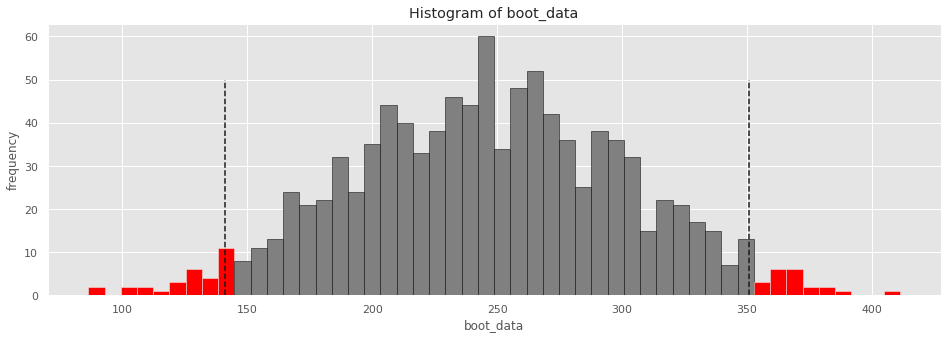

In [42]:
booted_data_ARPPU = get_bootstrap(full_groups.query('grp =="B" & payed == 1').revenue.fillna(0), full_groups.query('grp =="A" & payed == 1').revenue.fillna(0), statistic=arppu)

In [43]:
booted_data_ARPPU["p_value"] # есть значимое различие

5.938357710730867e-06

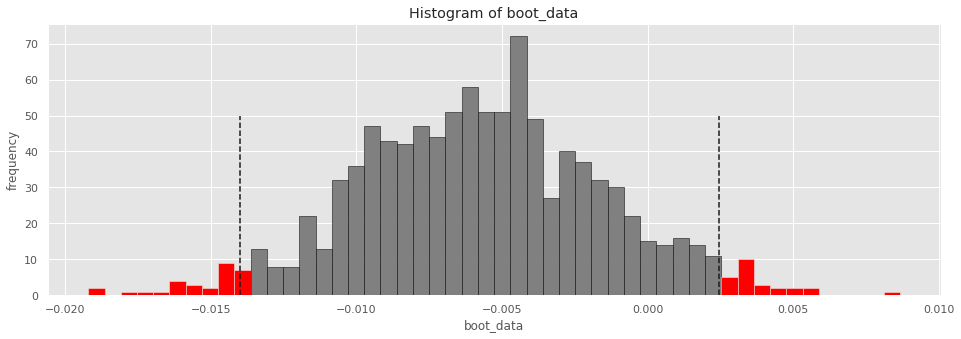

In [44]:
booted_cr = get_bootstrap(full_groups.query('grp =="B"').revenue.fillna(0), full_groups.query('grp =="A"').revenue.fillna(0), statistic=cr)

In [45]:
booted_cr["p_value"] # отсутствует значимое различие

0.1674166797875426

Для категориальных переменных (признаком "купил/не купил") можем провести дополнительныый тест на CR, использовав метод Хи-квадрат.

In [46]:
Metrics = Metrics.reset_index().rename(columns ={ "index": "group"})

In [47]:
Metrics

,group,payed_users,active_users,CR,ARPPU,ARPU,Mean_revenue
0,A,107,1567,6.83,860.71,58.77,860.71
1,B,434,6923,6.27,1108.82,69.51,1108.82


In [48]:
Metrics.query('group == "A"').active_users, Metrics.query('group == "A"').payed_users

(0    1567
 Name: active_users, dtype: int64,
 0    107
 Name: payed_users, dtype: int64)

In [49]:
# сделаем таблицу сопряженности
table = np.array([[Metrics.query('group == "A"').active_users, Metrics.query('group == "A"').payed_users],\
                [Metrics.query('group == "B"').active_users, Metrics.query('group == "B"').payed_users]])

In [50]:
chi2, prob, df, expected = stats.chi2_contingency(table)
print("p-value: {}".format(prob)) 

p-value: 0.4778925970224768


               Результат: p_value > 0.05 , это дает нам основание не отклонять нулевую гипотезу. 
               Различия не стат. значимы. Различий между группами нет.

# Вывод

При условии, что система сплитования в эксперименте сработала корректно и мы получили две репрезитативные выборки для анализа,  у нас есть достаточно оснований утвержать, что новая механика никак не повлияла конверсию покупателя в покупку. 

Также надо отметить один момент. Поскольку анализ проводился на совсем небольших выборках, с не одниковыми размерами и присуствием в данных шума(мое предположение что выбросы не случайны), было бы правильным шагом еще в конце измерить мощность, поскольку в центре эксперимента у нас очень важная биномиальная метрика - конверсия. Если полученая мощность  намного ниже предполагаемого порого (75-80 %), была бы необходимость в продолжении эксперимента и ждать пока получим выборки необходимого размера. Получили почти пороговый результат? Могли отвергнуть альтенативную гипотезу. 

## Задание 2. SQL

### 2.1 Очень усердные ученики.

**2.1.1 Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. 
Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**Задача. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.**

*Решение.*

In [51]:
import pandahouse as ph

In [52]:
# для подключения к таблице default в clickhouse:
connection_default = {'host': 'http://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [53]:
 # Оптимальный запрос о количестве учеников
 # Поскольку данные в таблице предствлены только за один месяц, считаю что если буду оринтироваться по последнему месяцу, то это будет также допустимо.
q = '''
       Select uniqExact(st_id) as diligent_students 
    From
        (SELECT st_id,
                sum(correct) as correct_answers
        FROM peas
        Where Month(timest) = (select max(month(timest)) from peas) 
        Group by st_id
        having  correct_answers >= 20) t1
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
diligent_students = ph.read_clickhouse(query=q, connection=connection_default)

In [54]:
print(f"Всего {diligent_students.diligent_students.iat[0]} усердных учеников за текущий месяц")

Всего 136 усердных учеников за текущий месяц


**2.2.1 Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день.  
Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ.     
          Команда провела эксперимент, где был протестирован новый экран оплаты.

**Задача. Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

*Решение.*

***Предворительно определим метрики***

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [55]:
q = '''
with 
    ARPU as (select a.test_grp, sum(money) / uniqExact(a.st_id) as ARPU from studs a
                  left join default.final_project_check b
                  using (st_id)
                  GROUP BY a.test_grp),
    ARPAU as (select a.test_grp, sum(money) / uniqExact(a.st_id) as ARPAU from studs a
              left join default.final_project_check b
              using (st_id)
              Where st_id in ( Select st_id from peas
                               Where correct = 1
                               Group by st_id
                               having count(correct) > 10)
             Group by test_grp),
    CR AS (select test_grp, count(distinct(b.st_id)) filter (where money != 0)  / count(distinct(st_id)) * 100 as CR from studs a
           left join final_project_check b
           using (st_id)
           GROUP BY test_grp),
    CR_active AS (select test_grp, count(distinct(b.st_id)) filter (where money != 0)  / count(distinct(st_id)) * 100 as CR_active from studs a
                  left join final_project_check b
                  using (st_id)
                  Where st_id in ( Select st_id from peas
                                   Where correct = 1
                                   Group by st_id
                                   having sum(correct) > 10)
                  Group by test_grp),
    CR_active_math as (select test_grp, count(distinct(b.st_id)) filter (where subject = 'Math')  / count(distinct(st_id)) * 100 as CR_active_math from studs a
                       left join final_project_check b
                       using (st_id)
                       Where st_id in ( Select st_id from peas
                                        Where subject = 'Math' and correct = 1
                                        Group by st_id
                                        having count(correct) >= 2)
                        Group by test_grp)

Select ARPU.test_grp as test_grp, round(ARPU.ARPU,2) as ARPU, round(ARPAU.ARPAU,2) as ARPAU, round(CR.CR,2) as CR, round(CR_active.CR_active,2) as CR_active, round(CR_active_math.CR_active_math, 2) as CR_active_math From  ARPU
join ARPAU on ARPU.test_grp = ARPAU.test_grp
join CR on ARPU.test_grp = CR.test_grp
join CR_active on ARPU.test_grp = CR_active.test_grp
join CR_active_math on ARPU.test_grp = CR_active_math.test_grp
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
metrics = ph.read_clickhouse(query=q, connection=connection_default)
metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


**Вывод**

На основе данных можно сделать вывод, что новый экран оплаты повысит все ключевые метрики платформы практически в два раза.

# Задание 3. Python

**3.1.1 Условие**

Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [56]:
def make_metrics():
    groups = pd.read_csv("Проект_2_groups.csv",sep= ";")
    group_add = pd.read_csv("Проект_2_group_add.csv",sep= ",")
    active_studs = pd.read_csv("Проект_2_active_studs.csv",sep= ";")
    checks = pd.read_csv("Проект_2_checks.csv",sep= ";")
    group_add.drop_duplicates()
    groups.rename(columns={ groups.columns[0]: "student_id"}, inplace = True) 
    group_add.rename(columns={ group_add.columns[0]: "student_id"}, inplace = True)
    checks.rename(columns={ checks.columns[1]: "revenue"}, inplace = True) 
    full_groups = groups.append(group_add)
    checks["payed"] = 1
    active_studs2 = checks.merge(active_studs, on = "student_id",how = "outer") 
    full_groups = active_studs2.merge(full_groups, on = "student_id",how = "left")
    Metrics = pd.DataFrame()
    Metrics["payed_users"] = full_groups.query("payed == 1").groupby("grp")\
                    .student_id.count()
    Metrics["active_users"] = full_groups.groupby("grp")\
                    .student_id.count()
    Metrics["CR"] = round(Metrics["payed_users"] / Metrics["active_users"] * 100,2)
    Metrics["ARPPU"] = round(full_groups.query("payed == 1").groupby("grp")\
                    .revenue.mean(),2)
    Metrics["ARPU"] = round(full_groups.groupby("grp")\
                    .revenue.sum() / Metrics["active_users"],2)
    Metrics["Mean_revenue"] = round(full_groups.query("payed == 1").groupby("grp").revenue.mean(),2)
    return Metrics

In [57]:
Metrics = make_metrics()
Metrics

,payed_users,active_users,CR,ARPPU,ARPU,Mean_revenue
A,107,1567,6.83,860.71,58.77,860.71
B,434,6923,6.27,1108.82,69.51,1108.82


**3.1.2 Условие**

Реализовать функцию, которая будет строить графики по получаемым метрикам.

In [58]:
def visualization_metrics(Metrics):
    Metrics = Metrics.reset_index().rename(columns={"index": "Group"})
    fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=False)
    fig.tight_layout(h_pad=4)
    sns.barplot(y='payed_users', x="Group", data=Metrics, ax=axs[0, 0]).set_title('payed_users')
    sns.barplot(y='active_users', x="Group", data=Metrics, ax=axs[0, 1]).set_title('active_users')
    sns.barplot(y='CR', x="Group", data=Metrics, ax=axs[0, 2]).set_title('Conversion')
    sns.barplot(y='ARPPU', x="Group", data=Metrics, ax=axs[1,0]).set_title('ARPPU')
    sns.barplot(y='ARPU', x="Group", data=Metrics, ax=axs[1,1]).set_title('ARPU')
    sns.barplot(y='Mean_revenue', x="Group", data=Metrics, ax=axs[1,2]).set_title('Mean_revenue')
    plt.show() 

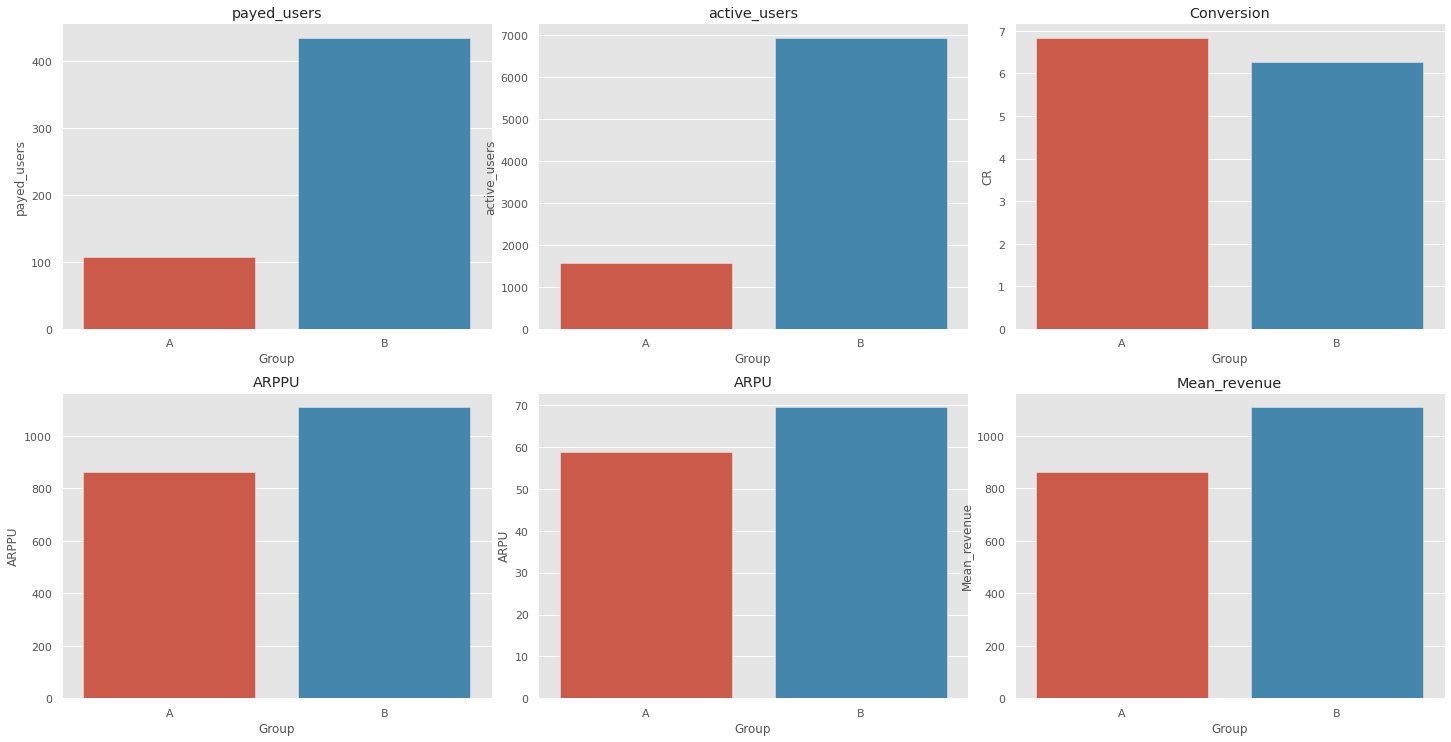

In [59]:
visualization_metrics(Metrics)